In [2]:
from fastai.vision.all import *
import fastai
import timm
import torch
import albumentations as A
transform = A.load("/media/newhd/OPTRetina/DMAE/autoalbument-amd/outputs/2021-11-24/10-32-22/policy/latest.json")

In [3]:
torch.cuda.set_device(0)

In [4]:
df = pd.read_csv('../trainValid.csv')

In [5]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [6]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 256

In [7]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='crossvit_15_dagger_408_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [9]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=408, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [10]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [20]:
learn = Learner(dls,timm.create_model('crossvit_15_dagger_408',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

SuggestedLRs(valley=2.0892961401841603e-05)

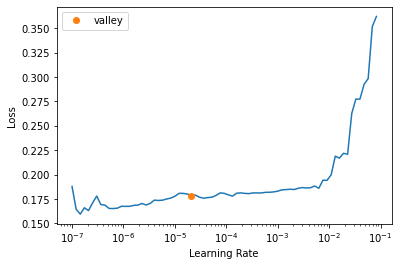

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.182439,0.181667,0.492308,0.495427,0.833333,0.621415,0.529543,04:39


Better model found at epoch 0 with f1_score value: 0.6214149139579349.


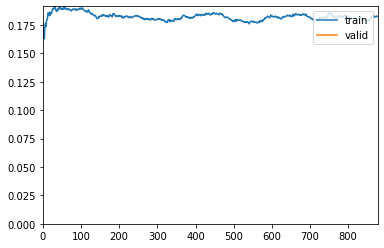

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.181448,0.178285,0.516667,0.510078,0.843590,0.635749,0.561949,04:43
1,0.179791,0.181640,0.503846,0.502262,0.853846,0.632479,0.535164,04:43
2,0.182366,0.177609,0.510256,0.506024,0.861538,0.637571,0.572110,04:43
3,0.177614,0.178761,0.517949,0.510638,0.861538,0.641221,0.551621,04:43
4,0.179791,0.176519,0.541026,0.524465,0.879487,0.657088,0.569402,04:43
5,0.181389,0.176032,0.517949,0.511041,0.830769,0.632812,0.568511,04:43
6,0.180063,0.175503,0.541026,0.524465,0.879487,0.657088,0.595697,04:43
7,0.178751,0.174868,0.550000,0.530806,0.861538,0.656891,0.592604,04:42
8,0.178072,0.175686,0.533333,0.520312,0.853846,0.646602,0.583840,04:43
9,0.179423,0.174484,0.517949,0.511076,0.828205,0.632094,0.581887,04:44


Better model found at epoch 0 with f1_score value: 0.6357487922705314.


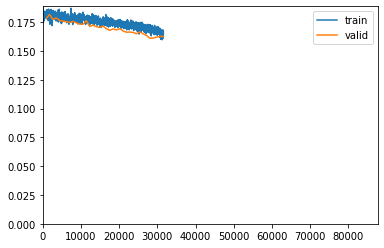

Better model found at epoch 2 with f1_score value: 0.6375711574952561.
Better model found at epoch 3 with f1_score value: 0.6412213740458016.
Better model found at epoch 4 with f1_score value: 0.657088122605364.
Better model found at epoch 13 with f1_score value: 0.6647000983284169.
Better model found at epoch 15 with f1_score value: 0.6679960119641076.
Better model found at epoch 19 with f1_score value: 0.6680161943319838.
Better model found at epoch 23 with f1_score value: 0.6762886597938146.
Better model found at epoch 24 with f1_score value: 0.6805708013172338.
Better model found at epoch 29 with f1_score value: 0.6942328618063112.
Better model found at epoch 31 with f1_score value: 0.7155555555555555.
No improvement since epoch 31: early stopping


In [21]:
learn.fine_tune(100,base_lr=3e-6)

In [22]:
dfTest = pd.read_csv('../testSample.csv')

In [23]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [24]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=408, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [25]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [26]:
learn.dls = dlsTest

In [27]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.7469044049967127.


(#6) [0.15927746891975403,0.6666666865348816,0.623199393479909,0.8430769230769231,0.7166521360069747,0.7469044049967127]